In [1]:
# visualization
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf', # ttf 파일이 저장되어 있는 경로
    name='NanumBarunGothic')                        # 이 폰트의 원하는 이름 설정
fm.fontManager.ttflist.insert(0, fe)              # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 10, 'font.family': 'NanumBarunGothic'}) # 폰트 설정
plt.rc('font', family='NanumBarunGothic')
import seaborn as sns

# utils
import pickle
import csv
import pandas as pd
import numpy as np
from tqdm import tqdm
import pickle
import warnings;warnings.filterwarnings('ignore')
import gdown
import joblib

# Model
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
import lightgbm as lgb

import eli5
from eli5.sklearn import PermutationImportance

import os
import glob

# 코드 셀 실행 후 경고를 무시
# import warnings
# warnings.filterwarnings(action='ignore')

### Load files

In [2]:
base_path = "/root/"

dt_train = pd.read_csv(base_path + "train.csv")
dt_test = pd.read_csv(base_path + "test.csv")

In [3]:
extra_data_path = '/root/extra_data/'

### values needed from dt_train before merge

In [4]:
dt_train['구'] = dt_train['시군구'].map(lambda x : x.split()[1])
dt_train['동'] = dt_train['시군구'].map(lambda x : x.split()[2])
# del dt_train['시군구']

dt_test['구'] = dt_test['시군구'].map(lambda x : x.split()[1])
dt_test['동'] = dt_test['시군구'].map(lambda x : x.split()[2])
# del dt_test['시군구']

In [5]:
dt_train = dt_train[dt_train['계약년월']>=201501]
dt_test = dt_test[dt_test['계약년월']>=201501]

In [6]:
dt_train_over2020 = dt_train[dt_train['계약년월']>=202001]

In [7]:
mean_val_by_gu = dt_train_over2020.groupby("구")["target"].mean().sort_values(ascending=False)
mean_val_by_dong = dt_train_over2020.groupby("동")["target"].mean().sort_values(ascending=False)
std_val_by_gu = dt_train_over2020.groupby("구")["target"].std().sort_values(ascending=False)
std_val_by_dong = dt_train_over2020.groupby("동")["target"].std().sort_values(ascending=False)

### Load Table from pickle

In [8]:
# pickle에서 데이터프레임 다시 불러오기
with open('/root/data.pickle', 'rb') as f:
    df = pickle.load(f)

In [9]:
df.columns

Index(['번지', '본번', '아파트명', '전용면적(㎡)', '계약년월', '층', '건축년도', '도로명', 'target',
       'is_test', '구', '동', '계약년', '계약월', '평균공시가격', '계약일', 'date'],
      dtype='object')

In [10]:
df = df[df['계약년월']>=201501]

### concat to process

In [11]:
# train/test 구분을 위한 칼럼을 하나 만들어 줍니다.
dt_train['is_test'] = 0
dt_test['is_test'] = 1

In [12]:
dt = pd.concat([dt_train, dt_test])

In [13]:
dt['is_test'].value_counts()

0    636736
1      9272
Name: is_test, dtype: int64

In [14]:
df['large_std_동'] = df['동']
df.drop(['동'], axis=1, inplace=True)

In [15]:
dt = dt.reset_index()

In [16]:
df['동'] = dt['동']

### 구 동 encoding of df

In [17]:
exp_dongs = ['청담동', '압구정동', '청담동', '삼성동', '도곡동', '반포동', '한남동', '성수동']
df["exp_dongs"] = df["동"].apply(lambda x : 1 if x in exp_dongs else 0)

In [18]:
order1_mean_gu = mean_val_by_gu.index.tolist()
order2_mean_dong = mean_val_by_dong.index.tolist()
order3_std_gu = std_val_by_gu.index.tolist()
order4_std_dong = std_val_by_dong.index.tolist()

# Create a dictionary to map district names to their corresponding label encoded values
gu_mapping1 = {district: label for label, district in enumerate(order1_mean_gu)}
gu_mapping2 = {district: label for label, district in enumerate(order3_std_gu)}
dong_mapping1 = {dong: label for label, dong in enumerate(order2_mean_dong)}
dong_mapping2 = {dong: label for label, dong in enumerate(order4_std_dong)}

df['구_encoded'] = df["구"].map(gu_mapping1)
df['구_std'] = df["구"].map(gu_mapping2)
df['동_encoded'] = df["동"].map(dong_mapping1)
df['동_std'] = df["동"].map(dong_mapping2)

In [19]:
df['yrs_diff'] = df['계약년월'].map(lambda x : x // 100) - df['건축년도']

In [20]:
df['is_public'] = dt["k-전용면적별세대현황(60㎡이하)"].notnull()

### 년도에따라 동, 구별 statistics 추가

In [21]:
stats = df.groupby(['계약년', '구'])['target'].agg(['std', 'mean', 'max'])
df = df.join(stats, on=['계약년', '구'], rsuffix='_target')

In [22]:
df['계약년과구에따른std'] = df['std']
df['계약년과구에따른mean'] = df['mean']
df['계약년과구에따른max'] = df['max']
df.drop(['std', 'mean', 'max'], axis=1, inplace=True)

In [23]:
stats = df.groupby(['계약년', '동'])['target'].agg(['std', 'mean', 'max'])
df = df.join(stats, on=['계약년', '동'], rsuffix='_target')

In [24]:
df['계약년과동에따른std'] = df['std']
df['계약년과동에따른mean'] = df['mean']
df['계약년과동에따른max'] = df['max']
df.drop(['std', 'mean', 'max'], axis=1, inplace=True)

In [25]:
# '계약년과동에따른std', '계약년과동에따른mean', '계약년과동에따른max'의 null 값을
# '계약년과구에따른std', '계약년과구에따른mean', '계약년과구에따른max'의 값으로 채우기
df['계약년과동에따른std'] = df['계약년과동에따른std'].fillna(df['계약년과구에따른std'])
df['계약년과동에따른mean'] = df['계약년과동에따른mean'].fillna(df['계약년과구에따른mean'])
df['계약년과동에따른max'] = df['계약년과동에따른max'].fillna(df['계약년과구에따른max'])

In [26]:
df.drop(['계약년과구에따른std', '계약년과구에따른mean', '계약년과구에따른max'], axis=1, inplace=True)

### yrs_diff 에따른 통계량 추가

In [27]:
stats = df.groupby(['yrs_diff', '구'])['target'].agg(['std', 'mean', 'max'])
df = df.join(stats, on=['yrs_diff', '구'], rsuffix='_target')

In [28]:
df['yrs_diff와구에따른std'] = df['std']
df['yrs_diff와구에따른mean'] = df['mean']
df['yrs_diff와구에따른max'] = df['max']
df.drop(['std', 'mean', 'max'], axis=1, inplace=True)

In [29]:
stats = df.groupby(['yrs_diff', '동'])['target'].agg(['std', 'mean', 'max'])
df = df.join(stats, on=['yrs_diff', '동'], rsuffix='_target')

In [30]:
df['yrs_diff와동에따른std'] = df['std']
df['yrs_diff와동에따른mean'] = df['mean']
df['yrs_diff와동에따른max'] = df['max']
df.drop(['std', 'mean', 'max'], axis=1, inplace=True)

In [31]:
# '계약년과동에따른std', '계약년과동에따른mean', '계약년과동에따른max'의 null 값을
# '계약년과구에따른std', '계약년과구에따른mean', '계약년과구에따른max'의 값으로 채우기
df['yrs_diff와동에따른std'] = df['yrs_diff와동에따른std'].fillna(df['yrs_diff와구에따른std'])
df['yrs_diff와동에따른mean'] = df['yrs_diff와동에따른mean'].fillna(df['yrs_diff와구에따른mean'])
df['yrs_diff와동에따른max'] = df['yrs_diff와동에따른max'].fillna(df['yrs_diff와구에따른max'])

In [32]:
df.drop(['yrs_diff와구에따른std', 'yrs_diff와구에따른mean', 'yrs_diff와구에따른max'], axis=1, inplace=True)

In [33]:
df.drop(['동', 'large_std_동', '본번'], axis=1, inplace=True)

### KOSPI 종가 delay

In [34]:
# Use glob to find all files that match the pattern
file_paths = glob.glob(extra_data_path + "/KOSPI_*.csv")

# Initialize an empty list to store the dataframes
dfs = []

# Iterate over the file paths and read each CSV file into a dataframe
for file_path in file_paths:
    kospi_df_yr = pd.read_csv(file_path, encoding="euc-kr")
    dfs.append(kospi_df_yr)

kospi_df = pd.concat(dfs, ignore_index=True)
kospi_df = kospi_df.drop(columns=['시가', '고가', '저가'])

In [35]:
kospi_df.rename(columns={"일자":"date", "종가":"Close"}, inplace=True)
kospi_df["date"] = kospi_df['date'].str.replace('/', '-')
kospi_df["date"] = pd.to_datetime(kospi_df["date"])
kospi_df.sort_values(by='date', ascending=True, inplace=True)

In [36]:
kospi_df["Close_delay120d"] = kospi_df["Close"].shift(120)

In [37]:
df.columns

Index(['번지', '아파트명', '전용면적(㎡)', '계약년월', '층', '건축년도', '도로명', 'target',
       'is_test', '구', '계약년', '계약월', '평균공시가격', '계약일', 'date', 'exp_dongs',
       '구_encoded', '구_std', '동_encoded', '동_std', 'yrs_diff', 'is_public',
       '계약년과동에따른std', '계약년과동에따른mean', '계약년과동에따른max', 'yrs_diff와동에따른std',
       'yrs_diff와동에따른mean', 'yrs_diff와동에따른max'],
      dtype='object')

In [38]:
df['date'] = pd.to_datetime(df['계약년'].astype(str) + '-' + df['계약월'].astype(str) + '-' + df['계약일'].astype(str))

In [39]:
df = pd.merge(left=df, right=kospi_df, on='date', how='left')

In [40]:
df.drop(columns=['Close', '대비', '등락률', '거래량', '거래대금', '상장시가총액'], inplace=True)

In [41]:
df["Close_delay120d"] = df["Close_delay120d"].interpolate(method='linear', axis=0)

In [42]:
df['date'] = df['date'].astype(str)

In [43]:
df.drop(['구', '구_std', '동_std', '계약년월', '계약년', '계약월', '계약일'], axis=1, inplace=True)

### 면적당단가 적용

In [44]:
df.columns

Index(['번지', '아파트명', '전용면적(㎡)', '층', '건축년도', '도로명', 'target', 'is_test',
       '평균공시가격', 'date', 'exp_dongs', '구_encoded', '동_encoded', 'yrs_diff',
       'is_public', '계약년과동에따른std', '계약년과동에따른mean', '계약년과동에따른max',
       'yrs_diff와동에따른std', 'yrs_diff와동에따른mean', 'yrs_diff와동에따른max',
       'Close_delay120d'],
      dtype='object')

In [45]:
df['ann_price_per_area'] = df['평균공시가격'] / df['전용면적(㎡)']

In [46]:
df['ann_price_per_area'].isnull().sum()

0

In [47]:
df['target_price_per_area'] = df['target'] / df['전용면적(㎡)']

In [48]:
df['target_price_per_area'].isnull().sum()

9272

In [49]:
# Sort the DataFrame by '도로명', '전용면적', and any relevant time column (if available)
df_sorted = df.sort_values(by=['도로명', '전용면적(㎡)', 'date'], ascending=True)

# Forward fill missing values in 'price_per_area' based on '도로명' and '전용면적'
df['target_price_per_area'] = df_sorted.groupby(['도로명', '전용면적(㎡)'])['target_price_per_area'].ffill()

# If there are any remaining missing values after forward fill, you can backfill them
df['target_price_per_area'] = df['target_price_per_area'].bfill()

In [50]:
df['target_price_per_area'].isnull().sum()

0

In [51]:
df['over_240'] = df['전용면적(㎡)'].apply(lambda x: 1 if x > 240 else 0)

In [52]:
df['over_240'].value_counts()

0    645029
1       979
Name: over_240, dtype: int64

In [53]:
df['maxfl'] = df_sorted.groupby('아파트명')['층'].transform('max')
df['is_maxfl'] = (df['층'] == df['maxfl']).astype(int)

In [54]:
df['is_maxfl'].value_counts()

0    618907
1     27101
Name: is_maxfl, dtype: int64

In [55]:
del df['maxfl']

In [56]:
df['over_27yrs'] = df['yrs_diff'].apply(lambda x: 1 if x > 27 else 0)

In [57]:
df['over_27yrs'].value_counts()

0    526483
1    119525
Name: over_27yrs, dtype: int64

### Feature Engineering

### Train

In [58]:
df_train = df.loc[df['is_test']==0, :]
df_test = df.loc[df['is_test']==1, :]

df_train.drop(['is_test'], axis=1, inplace=True)
df_test.drop(['is_test'], axis=1, inplace=True)
print(df_train.shape, df_test.shape)

(636736, 26) (9272, 26)


In [59]:
# 변수 삭제 및 파생변수 제작으로 추가된 변수들이 존재하기에, 다시한번 연속형과 범주형 칼럼을 분리해주겠습니다.
continuous_columns = []
categorical_columns = []

for column in df_train.columns:
    if pd.api.types.is_numeric_dtype(df_train[column]):
        continuous_columns.append(column)
    else:
        categorical_columns.append(column)

print("연속형 변수:", continuous_columns)
print("범주형 변수:", categorical_columns)

연속형 변수: ['전용면적(㎡)', '층', '건축년도', 'target', '평균공시가격', 'exp_dongs', '구_encoded', '동_encoded', 'yrs_diff', '계약년과동에따른std', '계약년과동에따른mean', '계약년과동에따른max', 'yrs_diff와동에따른std', 'yrs_diff와동에따른mean', 'yrs_diff와동에따른max', 'Close_delay120d', 'ann_price_per_area', 'target_price_per_area', 'over_240', 'is_maxfl', 'over_27yrs']
범주형 변수: ['번지', '아파트명', '도로명', 'date', 'is_public']


In [60]:
# 아래에서 범주형 변수들을 대상으로 레이블인코딩을 진행해 주겠습니다.

# 각 변수에 대한 LabelEncoder를 저장할 딕셔너리
label_encoders = {}

# Implement Label Encoding
for col in tqdm(categorical_columns):
    lbl = LabelEncoder()

    # Label-Encoding을 fit
    lbl.fit( df_train[col].astype(str) )
    df_train[col] = lbl.transform(df_train[col].astype(str))
    label_encoders[col] = lbl           # 나중에 후처리를 위해 레이블인코더를 저장해주겠습니다.

    # Test 데이터에만 존재하는 새로 출현한 데이터를 신규 클래스로 추가해줍니다.
    for label in np.unique(df_test[col]):
      if label not in lbl.classes_: # unseen label 데이터인 경우
        lbl.classes_ = np.append(lbl.classes_, label) # 미처리 시 ValueError발생하니 주의하세요!

    df_test[col] = lbl.transform(df_test[col].astype(str))

100%|██████████| 5/5 [00:01<00:00,  2.83it/s]


In [61]:
df_train0 = df_train[(df_train['전용면적(㎡)']<60)]
df_train60 = df_train[(df_train['전용면적(㎡)']>=60)&(df_train['전용면적(㎡)']<135)]
df_train135 = df_train[(df_train['전용면적(㎡)']>=135)]

In [62]:
X_test = df_test.drop(['target'], axis=1)
# X_test = X_test.drop(columns='Close_delay120d')
# X_test = X_test.drop(columns='계약년월')

X_test
X_test0 = X_test[(X_test['전용면적(㎡)']<60)]
X_test60 = X_test[(X_test['전용면적(㎡)']>=60)&(X_test['전용면적(㎡)']<135)]
X_test135 = X_test[(X_test['전용면적(㎡)']>=135)]

In [63]:
y_train0 = df_train0['target']
X_train0 = df_train0.drop(['target'], axis=1)


y_train60 = df_train60['target']
X_train60 = df_train60.drop(['target'], axis=1)

y_train135 = df_train135['target']
X_train135 = df_train135.drop(['target'], axis=1)

In [64]:
X_train0.columns

Index(['번지', '아파트명', '전용면적(㎡)', '층', '건축년도', '도로명', '평균공시가격', 'date',
       'exp_dongs', '구_encoded', '동_encoded', 'yrs_diff', 'is_public',
       '계약년과동에따른std', '계약년과동에따른mean', '계약년과동에따른max', 'yrs_diff와동에따른std',
       'yrs_diff와동에따른mean', 'yrs_diff와동에따른max', 'Close_delay120d',
       'ann_price_per_area', 'target_price_per_area', 'over_240', 'is_maxfl',
       'over_27yrs'],
      dtype='object')

In [65]:
drop_col_under135 = ['target_price_per_area', 'over_240', 'is_maxfl']
drop_col_over135 = ['ann_price_per_area', 'is_public', 'date']

In [66]:
X_train0.drop(columns=drop_col_under135, inplace=True)
X_test0.drop(columns=drop_col_under135, inplace=True)
X_train60.drop(columns=drop_col_under135, inplace=True)
X_test60.drop(columns=drop_col_under135, inplace=True)

In [67]:
# Split the data into train and validation sets
X_train0, X_val0, y_train0, y_val0 = train_test_split(X_train0, y_train0, test_size=0.2, random_state=2023)
X_train60, X_val60, y_train60, y_val60 = train_test_split(X_train60, y_train60, test_size=0.2, random_state=2023)

In [68]:
print(X_train0.shape, X_val0.shape)
print(X_train60.shape, X_val60.shape)

(196015, 22) (49004, 22)
(291853, 22) (72964, 22)


In [69]:
X_train0.columns

Index(['번지', '아파트명', '전용면적(㎡)', '층', '건축년도', '도로명', '평균공시가격', 'date',
       'exp_dongs', '구_encoded', '동_encoded', 'yrs_diff', 'is_public',
       '계약년과동에따른std', '계약년과동에따른mean', '계약년과동에따른max', 'yrs_diff와동에따른std',
       'yrs_diff와동에따른mean', 'yrs_diff와동에따른max', 'Close_delay120d',
       'ann_price_per_area', 'over_27yrs'],
      dtype='object')

In [70]:
gbm0 = lgb.LGBMRegressor(n_estimators=5000, max_depth=50, num_leaves=1200, min_child_samples=30,
                            feature_fraction=0.7,
                            bagging_fraction=0.9, verbosity=-1)



gbm60 = lgb.LGBMRegressor(n_estimators=5000, max_depth=50, num_leaves=1200, min_child_samples=30,
                            feature_fraction=0.7,
                            bagging_fraction=0.9, verbosity=-1)

In [71]:
gbm0.fit(
        X_train0, y_train0, 
        eval_set=[(X_train0, y_train0), (X_val0, y_val0)], 
        eval_metric='rmse',
        callbacks=[lgb.early_stopping(stopping_rounds=50),
                   lgb.log_evaluation(period=100, show_stdv=True)]
        )


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 2080.32	training's l2: 4.32771e+06	valid_1's rmse: 3547.25	valid_1's l2: 1.2583e+07
[200]	training's rmse: 1574.73	training's l2: 2.47976e+06	valid_1's rmse: 3461.81	valid_1's l2: 1.19841e+07
[300]	training's rmse: 1296.7	training's l2: 1.68143e+06	valid_1's rmse: 3452.84	valid_1's l2: 1.19221e+07
Early stopping, best iteration is:
[285]	training's rmse: 1331.54	training's l2: 1.77299e+06	valid_1's rmse: 3452.22	valid_1's l2: 1.19178e+07


LGBMRegressor(bagging_fraction=0.9, feature_fraction=0.7, max_depth=50,
              min_child_samples=30, n_estimators=5000, num_leaves=1200,
              verbosity=-1)

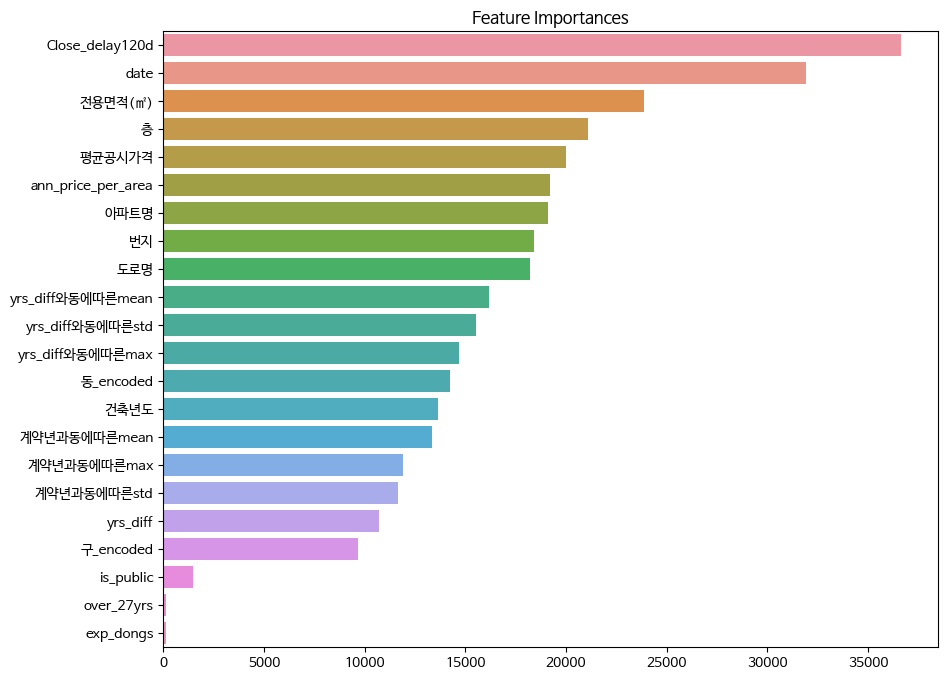

In [72]:
# 위 feature importance를 시각화해봅니다.
importances = pd.Series(gbm0.feature_importances_, index=list(X_train0.columns))
importances = importances.sort_values(ascending=False)

plt.figure(figsize=(10,8))
plt.title("Feature Importances")
sns.barplot(x=importances, y=importances.index)
plt.show()

In [73]:
# Permutation importance 방법을 변수 선택에 이용해보겠습니다.
perm = PermutationImportance(gbm0,        # 위에서 학습된 모델을 이용하겠습니다.
                             scoring="neg_mean_squared_error",        # 평가 지표로는 회귀문제이기에 negative rmse를 사용합니다. (neg_mean_squared_error : 음의 평균 제곱 오차)
                             random_state=42,
                             n_iter=3).fit(X_val0, y_val0)
eli5.show_weights(perm, feature_names=X_val0.columns.tolist())


Weight,Feature
305768149.6477 ± 4312252.9628,date
297109014.3072 ± 3719968.0484,평균공시가격
155057903.2772 ± 1829732.7812,전용면적(㎡)
85978875.6126 ± 1464052.4430,ann_price_per_area
23880666.5684 ± 402059.7724,구_encoded
20096376.7154 ± 152035.4899,건축년도
13271941.4517 ± 443479.4138,계약년과동에따른mean
7946173.9473 ± 62028.7777,yrs_diff
6555222.5758 ± 837190.7462,yrs_diff와동에따른max
5734256.4660 ± 131594.3704,Close_delay120d


In [74]:
gbm60.fit(
        X_train60, y_train60, 
        eval_set=[(X_train60, y_train60), (X_val60, y_val60)], 
        eval_metric='rmse',
        callbacks=[lgb.early_stopping(stopping_rounds=50),
                   lgb.log_evaluation(period=100, show_stdv=True)]
        )

Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 3825.66	training's l2: 1.46357e+07	valid_1's rmse: 5929.09	valid_1's l2: 3.51541e+07
[200]	training's rmse: 2919.83	training's l2: 8.52542e+06	valid_1's rmse: 5696.91	valid_1's l2: 3.24548e+07
[300]	training's rmse: 2458.78	training's l2: 6.04558e+06	valid_1's rmse: 5652.74	valid_1's l2: 3.19534e+07
[400]	training's rmse: 2131.28	training's l2: 4.54237e+06	valid_1's rmse: 5638.37	valid_1's l2: 3.17912e+07
[500]	training's rmse: 1881.07	training's l2: 3.53841e+06	valid_1's rmse: 5636.79	valid_1's l2: 3.17734e+07
Early stopping, best iteration is:
[491]	training's rmse: 1903.81	training's l2: 3.62451e+06	valid_1's rmse: 5636.06	valid_1's l2: 3.17652e+07


LGBMRegressor(bagging_fraction=0.9, feature_fraction=0.7, max_depth=50,
              min_child_samples=30, n_estimators=5000, num_leaves=1200,
              verbosity=-1)

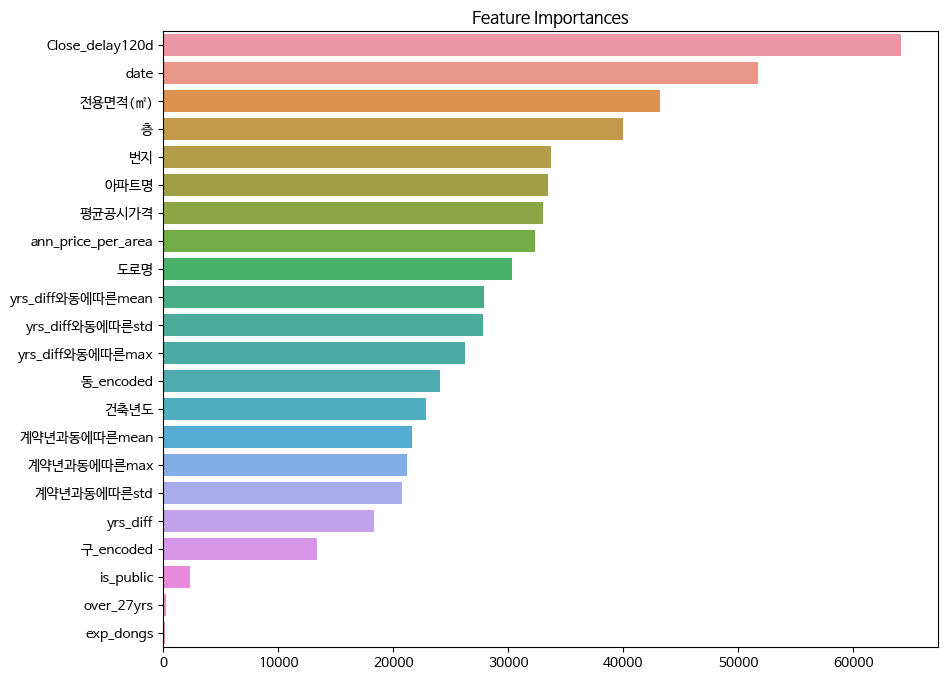

In [75]:
# 위 feature importance를 시각화해봅니다.
importances = pd.Series(gbm60.feature_importances_, index=list(X_train60.columns))
importances = importances.sort_values(ascending=False)

plt.figure(figsize=(10,8))
plt.title("Feature Importances")
sns.barplot(x=importances, y=importances.index)
plt.show()

In [76]:
# Permutation importance 방법을 변수 선택에 이용해보겠습니다.
perm = PermutationImportance(gbm60,        # 위에서 학습된 모델을 이용하겠습니다.
                             scoring = "neg_mean_squared_error",        # 평가 지표로는 회귀문제이기에 negative rmse를 사용합니다. (neg_mean_squared_error : 음의 평균 제곱 오차)
                             random_state = 42,
                             n_iter=3).fit(X_val60, y_val60)
eli5.show_weights(perm, feature_names = X_val60.columns.tolist())    # valid data에 대해 적합시킵니다.

Weight,Feature
668853892.2105 ± 5023538.2550,date
650889802.2885 ± 5675239.9891,평균공시가격
220968511.5710 ± 4846505.6927,전용면적(㎡)
205303694.0986 ± 1780447.8705,ann_price_per_area
58101012.2108 ± 890743.5180,구_encoded
49627864.4917 ± 511941.3676,건축년도
47471324.7080 ± 2006943.2717,yrs_diff와동에따른max
22191879.0257 ± 219745.4530,계약년과동에따른mean
13392260.4949 ± 511300.6635,yrs_diff와동에따른mean
11896733.0505 ± 57880.7799,도로명


### 135만 다르게 접근해야할 것 같음

In [77]:
print(X_train0.shape, X_val0.shape)
print(X_train60.shape, X_val60.shape)

(196015, 22) (49004, 22)
(291853, 22) (72964, 22)


In [78]:
X_train135.drop(columns=drop_col_over135, inplace=True)

In [79]:
X_test135.drop(columns=drop_col_over135, inplace=True)

In [80]:
X_train135.shape

(26900, 22)

In [81]:
# X_train135, X_val135

In [82]:
from sklearn.model_selection import KFold, cross_val_score

In [83]:
# Define the number of base learners for the ensemble
num_base_learners = 5

# Initialize an empty list to store the base learners
base_learners = []

num_folds = 5
# Define the k-fold cross-validator
kf = KFold(n_splits=num_folds, shuffle=True, random_state=2023)

# Perform k-fold cross-validation
for fold, (train_idx, val_idx) in enumerate(kf.split(X_train135), 1):
    print(f"Fold {fold}/{num_folds}")
    X_train_fold, X_val_fold = X_train135.iloc[train_idx], X_train135.iloc[val_idx]
    y_train_fold, y_val_fold = y_train135.iloc[train_idx], y_train135.iloc[val_idx]
    
    # Initialize a LightGBM regressor for the base learner
    gbm135 = lgb.LGBMRegressor(n_estimators=5000, max_depth=20, num_leaves=600, min_child_samples=10,
                            feature_fraction=0.7, bagging_fraction=0.9, verbosity=-1)
    
    # Train the base learner
    gbm135.fit(
            X_train_fold, y_train_fold, 
            eval_set=[(X_train_fold, y_train_fold), (X_val_fold, y_val_fold)], 
            eval_metric='rmse',
            callbacks=[lgb.early_stopping(stopping_rounds=50),
                       lgb.log_evaluation(period=100, show_stdv=True)]
            )
    
    # Add the trained base learner to the list
    base_learners.append(gbm135)

# Initialize an empty array to store predictions from each base learner
predictions = np.zeros(len(X_train135))

# Make predictions using each base learner and aggregate them
for gbm in base_learners:
    predictions += gbm.predict(X_train135)

# Take the average of the predictions to get the final prediction
ensemble_prediction = predictions / num_base_learners

Fold 1/5
Training until validation scores don't improve for 50 rounds


[100]	training's rmse: 2059.73	training's l2: 4.24247e+06	valid_1's rmse: 6889.94	valid_1's l2: 4.74712e+07
[200]	training's rmse: 1127.68	training's l2: 1.27167e+06	valid_1's rmse: 6779.63	valid_1's l2: 4.59634e+07
Early stopping, best iteration is:
[233]	training's rmse: 954.666	training's l2: 911388	valid_1's rmse: 6760.18	valid_1's l2: 4.57001e+07
Fold 2/5
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 1967.55	training's l2: 3.87124e+06	valid_1's rmse: 8185.4	valid_1's l2: 6.70008e+07
[200]	training's rmse: 1119.78	training's l2: 1.25391e+06	valid_1's rmse: 7955.26	valid_1's l2: 6.32861e+07
[300]	training's rmse: 704.488	training's l2: 496304	valid_1's rmse: 7875.78	valid_1's l2: 6.20279e+07
[400]	training's rmse: 470.922	training's l2: 221768	valid_1's rmse: 7835.04	valid_1's l2: 6.13879e+07
[500]	training's rmse: 328.724	training's l2: 108060	valid_1's rmse: 7810.04	valid_1's l2: 6.09967e+07
[600]	training's rmse: 230.367	training's l2: 53068.

In [84]:
ensemble_prediction.max()

1375701.107908386

In [85]:
real_test_pred0 = gbm0.predict(X_test0)
real_test_pred60 = gbm60.predict(X_test60)

In [86]:
X_test0['target'] = real_test_pred0
X_test60['target'] = real_test_pred60

In [87]:
# List to store predictions from base learners
predictions = []

# Iterate over base learners and get predictions for X_test135
for gbm in base_learners:
    predictions.append(gbm.predict(X_test135))

# Convert predictions to a NumPy array
predictions_array = np.array(predictions)

# Take the maximum prediction across the base learners
max_predictions = np.max(predictions_array, axis=0)

# Fill X_test135['target'] with the maximum predictions
X_test135['target'] = max_predictions


In [88]:
X_test135['target'].describe().round(2)

count        357.00
mean      283165.42
std       160621.86
min        40617.22
25%       174028.02
50%       245654.41
75%       354633.35
max      1181784.75
Name: target, dtype: float64

In [89]:
X_test0.columns

Index(['번지', '아파트명', '전용면적(㎡)', '층', '건축년도', '도로명', '평균공시가격', 'date',
       'exp_dongs', '구_encoded', '동_encoded', 'yrs_diff', 'is_public',
       '계약년과동에따른std', '계약년과동에따른mean', '계약년과동에따른max', 'yrs_diff와동에따른std',
       'yrs_diff와동에따른mean', 'yrs_diff와동에따른max', 'Close_delay120d',
       'ann_price_per_area', 'over_27yrs', 'target'],
      dtype='object')

In [90]:
X_test135.columns

Index(['번지', '아파트명', '전용면적(㎡)', '층', '건축년도', '도로명', '평균공시가격', 'exp_dongs',
       '구_encoded', '동_encoded', 'yrs_diff', '계약년과동에따른std', '계약년과동에따른mean',
       '계약년과동에따른max', 'yrs_diff와동에따른std', 'yrs_diff와동에따른mean',
       'yrs_diff와동에따른max', 'Close_delay120d', 'target_price_per_area',
       'over_240', 'is_maxfl', 'over_27yrs', 'target'],
      dtype='object')

In [91]:
X_test0.drop(['date', 'is_public', 'ann_price_per_area'], axis=1, inplace=True)
X_test60.drop(['date', 'is_public', 'ann_price_per_area'], axis=1, inplace=True)
X_test135.drop(['target_price_per_area', 'over_240', 'is_maxfl'], axis=1, inplace=True)

In [92]:
# concat

concat_test = pd.concat([X_test0, X_test60, X_test135], axis=0)
concat_test = concat_test.sort_index()
concat_test


,번지,아파트명,전용면적(㎡),층,건축년도,도로명,평균공시가격,exp_dongs,구_encoded,동_encoded,yrs_diff,계약년과동에따른std,계약년과동에따른mean,계약년과동에따른max,yrs_diff와동에따른std,yrs_diff와동에따른mean,yrs_diff와동에따른max,Close_delay120d,over_27yrs,target
636736,4682,319,79.9700,5,1987,6025,120960.000000,0,0,NaN,36,112520.254068,208005.081699,900000.0,78047.338623,180069.893485,540000.0,2449.800000,1,206188.643187
636737,4657,320,108.2017,10,2021,464,155775.000000,0,0,NaN,2,112520.254068,208005.081699,900000.0,103660.430459,169122.259048,1450000.0,2465.100000,0,284885.075476
636738,4658,324,161.0000,15,1984,462,182537.777778,0,0,NaN,39,112520.254068,208005.081699,900000.0,88521.744758,209776.336634,595000.0,2480.400000,1,368122.867929
636739,4658,324,133.4600,14,1984,462,182537.777778,0,0,NaN,39,112520.254068,208005.081699,900000.0,88521.744758,209776.336634,595000.0,2475.480000,1,298672.733761
636740,4658,324,104.4300,6,1984,462,182537.777778,0,0,NaN,39,112520.254068,208005.081699,900000.0,88521.744758,209776.336634,595000.0,2439.090000,1,229733.115630
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
646003,5716,3617,84.6500,13,2014,5423,39021.326676,0,22,NaN,9,27142.558383,56865.823529,185000.0,22509.608301,41454.276316,208000.0,2428.570000,0,70926.936248
646004,5716,3617,84.6200,12,2014,5423,39021.326676,0,22,NaN,9,27142.558383,56865.823529,185000.0,22509.608301,41454.276316,208000.0,2425.080000,0,70550.706011
646005,5716,3617,101.6500,12,2014,5423,39021.326676,0,22,NaN,9,27142.558383,56865.823529,185000.0,22509.608301,41454.276316,208000.0,2420.253333,0,84510.626167
646006,5716,3617,84.9400,18,2014,5423,39021.326676,0,22,NaN,9,27142.558383,56865.823529,185000.0,22509.608301,41454.276316,208000.0,2415.426667,0,67802.547816


In [93]:

# X_test에서 target만 분리.

ttt = concat_test.loc[:,'target']
ttt = pd.DataFrame(ttt)

ttt= ttt.reset_index()

preds_df= ttt.drop(columns='index')
preds_df= ttt.drop(columns='index')

preds_df2 = pd.DataFrame(preds_df['target'].astype(int), columns=["target"])
preds_df2

preds_df2.to_csv('gu-dong-encoded_0401_5pm_yoon.csv', index=False)



In [94]:
preds_df2.describe().round(2)

,target
count,9272.00
mean,106532.15
std,74050.83
min,9159.00
25%,62842.25
50%,88339.00
75%,125181.50
max,1181784.00
